In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix
import os

#Step 1: Data Loading and Preprocessing

In [2]:
train_data=pd.read_csv('/content/marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv',sep='\t')
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [3]:
train_data = train_data[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
train_data.head(3)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...


In [4]:
train_data['Product Tags']

,Product Tags
0,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,"Gillette TRAC II Plus Razor Blade Refills, Fit..."
...,...
1164,"Pantene Pro-V Curl Perfection, Moisturizing Co..."
1165,Maybelline New York Lash Stiletto Ultimate Len...
1166,Keep it Kind Fresh Kidz Girls &quotPurple&quot...
1167,MyRemede Hand Sanitizer 9.46 fl oz 2 Bottle Pa...


In [5]:
train_data.isna().sum()

,0
Uniq Id,0
Product Id,0
Product Rating,550
Product Reviews Count,275
Product Category,4
Product Brand,1
Product Name,0
Product Image Url,1
Product Description,211
Product Tags,1


In [6]:
# Fill missing values in 'Product Rating' with a default value (e.g., 0)
train_data['Product Rating'].fillna(0, inplace=True)
# Fill missing values in 'Product Reviews Count' with a default value (e.g., 0)
train_data['Product Reviews Count'].fillna(0, inplace=True)
# Fill missing values in 'Product Category' with a default value (e.g., 'Unknown')
train_data['Product Category'].fillna('', inplace=True)
# Fill missing values in 'Product Brand' with a default value (e.g., 'Unknown')
train_data['Product Brand'].fillna('', inplace=True)
# Fill missing values in 'Product Description' with an empty string
train_data['Product Description'].fillna('', inplace=True)

In [7]:
train_data.isna().sum()

,0
Uniq Id,0
Product Id,0
Product Rating,0
Product Reviews Count,0
Product Category,0
Product Brand,0
Product Name,0
Product Image Url,1
Product Description,0
Product Tags,1


In [8]:
train_data.duplicated().sum()

0

In [9]:
# make columns shorter
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}
# Rename the columns using the mapping
train_data.rename(columns=column_name_mapping, inplace=True)

In [10]:
train_data.columns

Index(['ID', 'ProdID', 'Rating', 'ReviewCount', 'Category', 'Brand', 'Name',
       'ImageURL', 'Description', 'Tags'],
      dtype='object')

In [11]:
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)

#Step 2: EDA (Exploratory Data Analysis)

In [12]:
# Basic statistics
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
num_ratings = train_data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 541
Number of unique items: 500
Number of unique ratings: 29


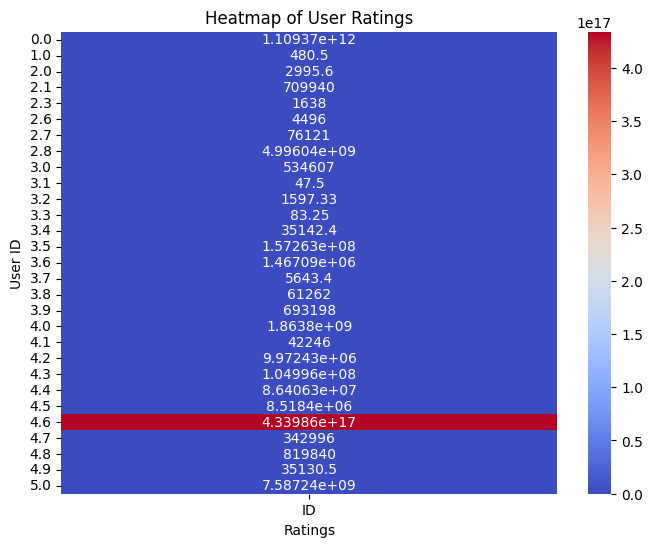

In [13]:
# Pivot the DataFrame to create a heatmap
heatmap_data = train_data.pivot_table('ID', 'Rating')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

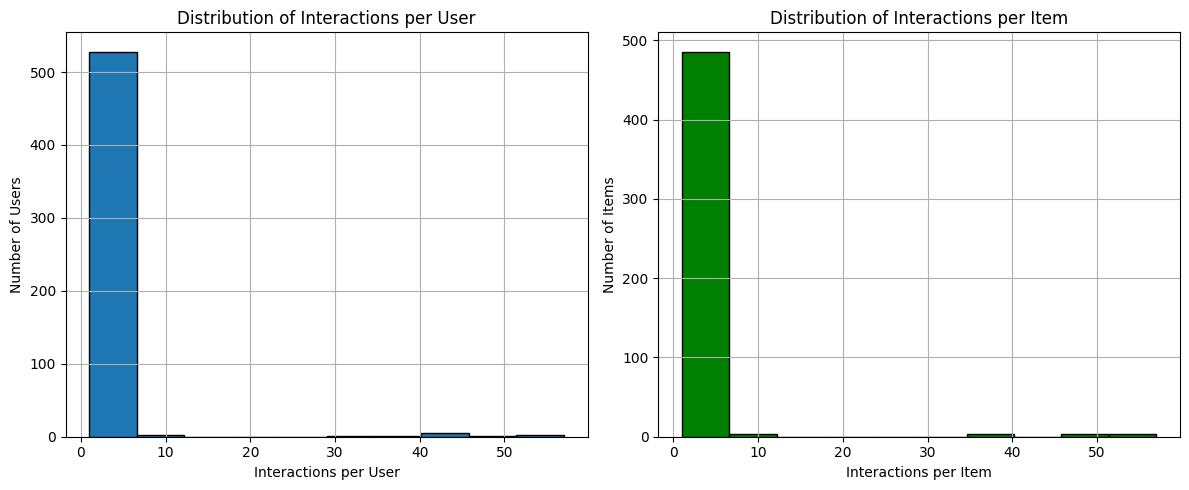

In [14]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
train_data['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular items')

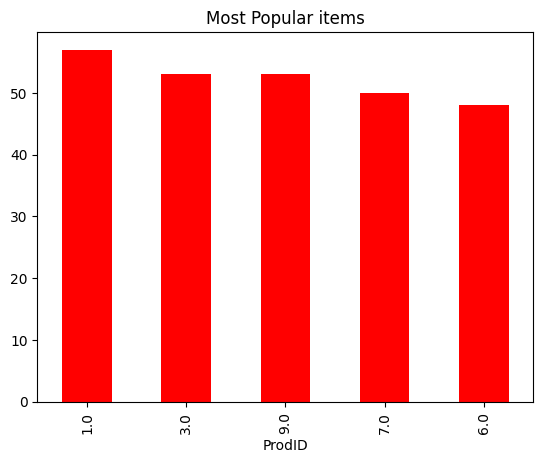

In [15]:
# Most popular items
popular_items = train_data['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

<Axes: xlabel='Rating'>

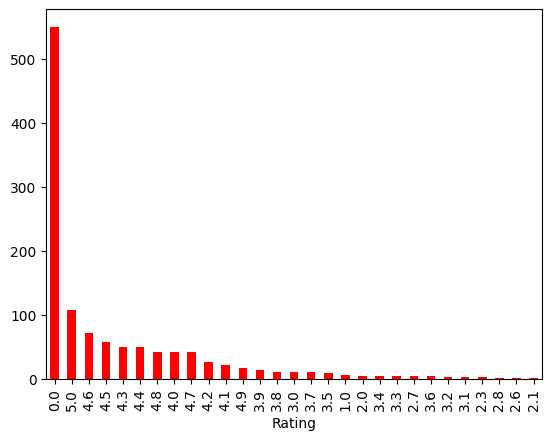

In [16]:
# most rated counts
train_data['Rating'].value_counts().plot(kind='bar',color='red')

#Step 3: Data Cleaning and Tags Creations

In [17]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
    train_data[column] = train_data[column].apply(clean_and_extract_tags)

In [18]:
# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

#Rating Base Recommendations System

In [19]:
average_ratings = train_data.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()

In [20]:
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

rating_base_recommendation = top_rated_items.head(10)

In [21]:
rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)

In [22]:
print("Rating Base Recommendation System: (Trending Products)")
rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]
rating_base_recommendation

Rating Base Recommendation System: (Trending Products)


,Name,ReviewCount,Brand,ImageURL,Rating
71,5 Bottles PURE Plant Therapy Lymphatic Drainag...,1,unbrand,https://i5.walmartimages.com/asr/cfa266d0-977c...,5
1052,"Summers Eve Individually Wrapped Cloths, Aloe ...",10,"summer, eve",https://i5.walmartimages.com/asr/64f9e76d-373c...,5
130,"Amazing Grass Plant Protein Superfood Powder, ...",1,"amazing, grass",https://i5.walmartimages.com/asr/e9cfcc21-aff0...,5
87,APRICOT KERNEL OIL REFINED ORGANIC CARRIER COL...,1,"oils, center",https://i5.walmartimages.com/asr/d71cf73a-1a5a...,5
86,"ACT Braces Care Anticavity Mouthwash (18 Oz, C...",32,act,https://i5.walmartimages.com/asr/a7fa6e41-316f...,5
203,Burts Bees Mama Bee Nourishing Body Oil with V...,1,"burt, bees",https://i5.walmartimages.com/asr/e7a72b68-41ae...,5
900,Pure Essential Oil Works Top 6 Essential Oil K...,1,"pure, essential, oil, works",https://i5.walmartimages.com/asr/986f6331-813c...,5
1060,Swisspers Cotton Balls 200 Each,5,swisspers,https://i5.walmartimages.com/asr/abc61940-0a5a...,5
899,"ProsourceFit Grippy Yoga Gloves, Non-Slip Fing...",4,prosourcefit,https://i5.walmartimages.com/asr/53203f1c-6a23...,5
427,Floral Set of 6 Fragrance Oils - Premium Grade...,1,,https://i5.walmartimages.com/asr/812fb19d-3eee...,5


#Content Base Recommendation system (User Preferences or Items similarities)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])
cosine_similarities_content = cosine_similarity(tfidf_matrix_content,tfidf_matrix_content)

In [24]:
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
item_index = train_data[train_data['Name']==item_name].index[0]

In [25]:
similar_items = list(enumerate(cosine_similarities_content[item_index]))

In [26]:
similar_items = sorted(similar_items, key=lambda x:x[0], reverse=True)
top_similar_items = similar_items[1:10]

recommended_items_indics = [x[0] for x in top_similar_items]

In [27]:
train_data.iloc[recommended_items_indics][['Name','ReviewCount','Brand']]

,Name,ReviewCount,Brand
1167,MyRemede Hand Sanitizer 9.46 fl oz 2 Bottle Pa...,1.0,myremede
1166,Keep it Kind Fresh Kidz Girls &quotPurple&quot...,3.0,kind2skin
1165,Maybelline New York Lash Stiletto Ultimate Len...,0.0,maybelline
1164,"Pantene Pro-V Curl Perfection, Moisturizing Co...",360.0,pantene
1163,Moisturizing Conditioner - Peach Case Pack 12,0.0,jrheller
1162,Gillette Clinical Soft Solid Sport Triumph Ant...,151.0,gillette
1161,Seventh Generation Free & Clear Fragrance Free...,238.0,"seventh, generation"
1160,Sensodyne Pronamel Intensive Enamel Repair Too...,78.0,sensodyne
1159,"Flat Tummy, 2-Step Detox Tea, 2-Week Program",12.0,"flat, tummy"


#Function To Recommend Products for Content Base

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

In [29]:
# Example: Get content-based recommendations for a specific item
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0


In [30]:
# Example: Get content-based recommendations for a specific item
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
546,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0
100,"Black Radiance Perfect Tone Matte Lip Crème, S...",27.0,"black, radiance",https://i5.walmartimages.com/asr/a1fdace5-049c...,4.9
868,Maybelline SuperStay Matte Ink Liquid Lipstick...,7605.0,maybelline,https://i5.walmartimages.com/asr/bc5745df-6376...,4.4
1049,"Rimmel Stay Matte Liquid Lip Colour, Fire Star...",594.0,rimmel,https://i5.walmartimages.com/asr/b26c976c-0bcc...,0.0
181,"Rimmel Stay Matte Liquid Lip Colour, Mwah",586.0,rimmel,https://i5.walmartimages.com/asr/bfaa7762-31d9...,4.2
938,"Rimmel Stay Matte Liquid Lip Colour, Strapless...",592.0,rimmel,https://i5.walmartimages.com/asr/e0849504-9377...,0.0
1109,"Rimmel Stay Matte Liquid Lip Colour, Pink Bliss",586.0,rimmel,https://i5.walmartimages.com/asr/27abe50c-3aab...,4.2
838,Maybelline SuperStay Matte Ink Liquid Lipstick...,214.0,maybelline,https://i5.walmartimages.com/asr/57585e70-7047...,4.3


#Collaborative Filtering (User Item Similarity)

In [32]:
train_data.head(2)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium, beauty, premium, makeup, premium, nai..."
1,9.500000e+01,76.0,0.0,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","beauty, hair, care, hair, color, auburn, hair,..."


In [33]:
user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating',aggfunc='mean').fillna(0).astype(int)


In [34]:
user_similarity = cosine_similarity(user_item_matrix)

In [35]:
target_user_id = 4
target_user_index = user_item_matrix.index.get_loc(target_user_id)

In [36]:
user_similarities = user_similarity[target_user_index]

similar_user_indices = user_similarities.argsort()[::-1][1:]

In [37]:
recommend_items = []

for user_index in similar_user_indices:
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    not_rated_by_target_user = (rated_by_similar_user==0) & (user_item_matrix.iloc[target_user_index]==0)

    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

recommended_items_details = train_data[train_data['ProdID'].isin(recommend_items)][['Name','ReviewCount','Brand','ImageURL','Rating']]

In [38]:
recommended_items_details.head(10)

,Name,ReviewCount,Brand,ImageURL,Rating
2,Clairol Nice N Easy Permanent Color 7/106A Nat...,29221.0,clairol,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,4.5
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
33,"DenTek Kids Fun Flossers, Removes Food & Plaqu...",3.0,dentek,https://i5.walmartimages.com/asr/de6e52eb-6e18...,0.0
59,Dr. Hauschka Revitalizing Day Cream (Formerly ...,0.0,"dr, hauschka",https://i5.walmartimages.com/asr/330bb65f-24fc...,0.0
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
64,Neutrogena SkinClearing Oil-Free Liquid Founda...,741.0,neutrogena,https://i5.walmartimages.com/asr/fd4d78d8-310a...,4.2
69,Design Essentials Natural Coconut & Monoi Curl...,1.0,"design, essentials",https://i5.walmartimages.com/asr/ff2dba1d-0c02...,5.0
78,"Paul Sebastian Fine Cologne Spray, Cologne for...",28.0,"paul, sebastian",https://i5.walmartimages.com/asr/03d08a07-18d7...,4.8
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
92,"Bytewise Organic Moringa Leaf Powder, 12 Oz",0.0,bytewise,https://i5.walmartimages.com/asr/076f2b3f-fdc3...,0.0


#Function That Recommend Items

In [41]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details.head(top_n)


In [42]:
# Example usage
target_user_id = 4
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec

Top 5 recommendations for User 4:


,Name,ReviewCount,Brand,ImageURL,Rating
2,Clairol Nice N Easy Permanent Color 7/106A Nat...,29221.0,clairol,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,4.5
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
59,Dr. Hauschka Revitalizing Day Cream (Formerly ...,0.0,"dr, hauschka",https://i5.walmartimages.com/asr/330bb65f-24fc...,0.0
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
64,Neutrogena SkinClearing Oil-Free Liquid Founda...,741.0,neutrogena,https://i5.walmartimages.com/asr/fd4d78d8-310a...,4.2
69,Design Essentials Natural Coconut & Monoi Curl...,1.0,"design, essentials",https://i5.walmartimages.com/asr/ff2dba1d-0c02...,5.0
78,"Paul Sebastian Fine Cologne Spray, Cologne for...",28.0,"paul, sebastian",https://i5.walmartimages.com/asr/03d08a07-18d7...,4.8
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
92,"Bytewise Organic Moringa Leaf Powder, 12 Oz",0.0,bytewise,https://i5.walmartimages.com/asr/076f2b3f-fdc3...,0.0
94,Ag Hair Cosmetics Ultradynamics Extra-Firm Fin...,0.0,"ag, hair",https://i5.walmartimages.com/asr/5d217d98-a385...,0.0


In [43]:
#Hybrid Recommendations

In [44]:
# Hybrid Recommendations (Combine Content-Based and Collaborative Filtering)
def hybrid_recommendations(train_data,target_user_id, item_name, top_n=10):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(train_data,item_name, top_n)

    # Get collaborative filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendations(train_data,target_user_id, top_n)

    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()

    return hybrid_rec.head(10)

In [45]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 4 # Change this to the user_id you want recommendations for
item_name = "OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11"  # Change this to the item name
hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 4 and Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11':


,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi,https://i5.walmartimages.com/asr/98b4194c-e026...,0.0
1042,"OPI GelColor Gel Nail Polish, Dulce De Leche, ...",1.0,opi,https://i5.walmartimages.com/asr/c1b2c370-b2d2...,0.0


In [46]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 10 # Change this to the user_id you want recommendations for
item_name = 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum'

hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 10 and Item 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum':


,Name,ReviewCount,Brand,ImageURL,Rating
896,"Black Radiance Perfect Tone Lip Color, Vintage...",78.0,"black, radiance",https://i5.walmartimages.com/asr/485f26b4-a19a...,4.7
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0
420,Black Opal Color Splurge Sassy Luxe Matte Lips...,0.0,"black, opal",https://i5.walmartimages.com/asr/a991241b-e4ad...,0.0
546,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0
826,Covergirl Outlast UltiMatte One Step Liquid Li...,1.0,covergirl,https://i5.walmartimages.com/asr/2ed7a79f-8a35...,5.0
868,Maybelline SuperStay Matte Ink Liquid Lipstick...,7605.0,maybelline,https://i5.walmartimages.com/asr/bc5745df-6376...,4.4
1049,"Rimmel Stay Matte Liquid Lip Colour, Fire Star...",594.0,rimmel,https://i5.walmartimages.com/asr/b26c976c-0bcc...,0.0
181,"Rimmel Stay Matte Liquid Lip Colour, Mwah",586.0,rimmel,https://i5.walmartimages.com/asr/bfaa7762-31d9...,4.2
938,"Rimmel Stay Matte Liquid Lip Colour, Strapless...",592.0,rimmel,https://i5.walmartimages.com/asr/e0849504-9377...,0.0
1109,"Rimmel Stay Matte Liquid Lip Colour, Pink Bliss",586.0,rimmel,https://i5.walmartimages.com/asr/27abe50c-3aab...,4.2
